# Usage

This page documents basic concepts and functionality within `scipeds`.

## The Data

First things first: `scipeds` is all about IPEDS data. While IPEDS provides an incredibly rich set of data across multiple decades, the data is split out across different files and formats on the IPEDS [data portal](https://nces.ed.gov/ipeds/datacenter/DataFiles.aspx), making it challenging to do anything but the most basic analyses. 

One key thing we've done with `scipeds` is to standardize and centralize this data across multiple years into a single, query-able database. That database file is critical to using `scipeds`, so downloading it is the first step.

For this tutorial, we'll be focusing on IPEDS completions data. That said, we've written `scipeds` in a way that should make it easy to add other survey components like admissions and enrollment. As the package expands, approaches and concepts similar to the ones we share here will apply to these new IPEDS survey components.

In [1]:
import scipeds

# Download the pre-processed database. You can control
# the file location by setting the SCIPEDS_CACHE_DIR
# environment variable or by specifying an output_path parameter.
# If nothing is provided (as in the example here),
# this path Defaults to platformdirs' user_cache_dir.
scipeds.download_db()

Database already downloaded to /Users/cjk/Library/Caches/.scipeds/scipeds_0_0_7.duckdb. To re-download and overwrite the existing file, re-run with `overwrite` set to `True`(from within Python) or add --overwrite to your CLI command.


Now that the database is downloaded, we can use the IPEDS Completions Query Engine to query it.

## The Query Engine

`scipeds` is really just a thin wrapper for aggregating the pre-processed IPEDS data using SQL queries. This thin wrapper is implemented in the `CompletionsQueryEngine`, which is what we'll use to work with the pre-processed database file that we just downloaded.

In [2]:
from scipeds.data.completions import CompletionsQueryEngine

engine = CompletionsQueryEngine()

We also provide a few other tools in `scipeds` that makes it possible to construct different kinds of queries of the completions data. 

In particular, we provide tools for filtering data and aggregating data across fields in the `scipeds.data.queries` submodule, and convenience enumerations in `scipeds.data.enums` that make it easier to specify the values you want to filter on without having to remember how every variable is specifically spelled.

We'll start by importing these helper tools and initializing the completions query engine.

In [3]:
# Convenience tools for specifying different variables

from scipeds.data.enums import (
    AwardLevel,
    FieldTaxonomy,
    Grouping,
    NCSESSciGroup,
    RaceEthn,
)

# Tools for filtering data and aggregating fields within a taxonomy

from scipeds.data.queries import (
    QueryFilters,
    TaxonomyRollup,
)

In [4]:
# If you used a non-default location when you downlaoded
# the pre-processed database, you should specify that location
# with the db_path parameter here.
engine = CompletionsQueryEngine()

### Filtering the underlying data

First, we'll walk through how to use our pre-written wrappers to query the completions data.

All of the pre-written queries take a `QueryFilter` as input. This defines the set of filters that are applied to the underlying data before any aggregations are done. For example, you can use a `QueryFilter` to specify which years of data you want and to limit your results to just Bachelor's degrees.


In [5]:
filters = QueryFilters(
    # The first year you want to include in your aggregation
    # (default: 1984)
    start_year=2022,
    # The last year you want to include in your aggregation
    # (default: 2023)
    end_year=2022,
    # The racial/ethnic groups you want to include
    # (default: all racial / ethnic groups)
    race_ethns=list(RaceEthn),
    # The award levels you want to include
    # (default: all award levels)
    award_levels=[AwardLevel.bachelors],
    # The major numbers you want to include
    # (default: both first and second majors)
    majornums=[1, 2],
)

There's a few enumerations we use and provide that make it so you don't have to remember the exact string values for different variables. For instance, `RaceEthn` is an enumeration of the different race/ethnicity groups present in the dataset, `Degree` is an enumeration of all the award levels available, etc.

### Rolling up over fields

The underlying completions table that we're looking at provides the total number of awards for each individual CIP code. Because we're usually interested in high-level field groupings (rather than individual CIP codes), we created a `TaxonomyRollup` which you use to tell `scipeds` the fields within a type of field grouping that you want to aggregate together. 

There are two main concepts in the `TaxonomyRollup`:

- The `taxonomy_name`, which defines which approach for grouping fields you want to use. For example, NCSES provides taxonomies for grouping CIP codes into broad field groups (like "Math & Computer Sciences") and detailed field groups (like "Computer Science"). You can see the options available in the enumeration `FieldTaxonomy`. Enumerated values are defined for some columns like the NCSES Science Group (`NCSESSciGroup`), but not for others (like CIP code) because there are simply too many values.
- The `taxonomy_values`, which is a list of fields from the taxonomy you've chosen that you want to aggregate over. These are also available as enumerations, with each type of `FieldTaxonomy` having their own set of enumerated fields. 

For the following examples, we'll be looking at the NCSES broadest categorization, aggregating over all fields that NCSES has categorized as "Science & Engineering". We do this by specifying the `ncses_sci_group` taxonomy and including any fields that are marked as `NCSESSciGroup.sci`.

In [6]:
ncses_stem = TaxonomyRollup(
    taxonomy_name=FieldTaxonomy.ncses_sci_group,
    taxonomy_values=[NCSESSciGroup.sci],
)

If you want to see which CIP codes are included in each `FieldTaxonomy`, you can get a table with all of the CIP codes and their respective categorizations with the `.get_cip_table()` function:

In [7]:
engine.get_cip_table()

,cip_title,ncses_sci_group,ncses_field_group,ncses_detailed_field_group,nsf_broad_field,dhs_stem
cip2020,,,,,,
01.0000,"Agriculture, General",Science and engineering,Life Sciences,Agricultural Sciences,Agricultural and biological sciences,False
01.0101,"Agricultural Business and Management, General",Non-science and engineering,Business and Management,Business and Management,Non-science and engineering,False
01.0102,Agribusiness/Agricultural Business Operations,Non-science and engineering,Business and Management,Business and Management,Non-science and engineering,False
01.0103,Agricultural Economics,Science and engineering,Social Sciences,Economics,Social and behavioral sciences,False
01.0104,Farm/Farm and Ranch Management,Non-science and engineering,Business and Management,Business and Management,Non-science and engineering,False
...,...,...,...,...,...,...
61.2707,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NSF broad field classification,False
61.2801,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NSF broad field classification,False
80.9999,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NSF broad field classification,False


### Pre-written queries to roll up across fields

Now that we've specified how we want to filter the raw data and which fields we want to aggregate over, we can run through some of the queries we've pre-written.

#### Aggregate by gender

First, we can calculate the total number of completions by gender by using the `rollup_by_grouping` function provided by the `CompletionsQueryEngine`. Remember: this will return the total completions across all of the fields we've specified (the `rollup` parameter), subject to the filters we've specified (the `query_filters` parameter).

In [8]:
# Aggregate total bachelor's degree completions in 2022 in STEM fields
# by gender, including all races and both first and second majors
stem_completions_by_gender = engine.rollup_by_grouping(
    grouping=Grouping.gender,
    rollup=ncses_stem,
    query_filters=filters,
)
stem_completions_by_gender

,rollup_degrees_within_gender,rollup_degrees_total,uni_degrees_within_gender,uni_degrees_total
gender,,,,
men,381882,798298,884320,2138714
women,416416,798298,1254394,2138714


The returned dataframe contains four columns:

* `rollup_degrees_within_gender` contains the number of degrees awarded across the fields specified by the `TaxonomyRollup` to members of the group specified in the row
* `rollup_degrees_total` contains the total number of degrees awarded across the fields specified by the `TaxonomyRollup` across all groups in the grouping
* `uni_degrees_within_gender` contains the total number of degrees awarded in all fields to members of the group specified in the row
* `uni_degrees_total` contains the total number of degrees awarded in all fields across all groups in the grouping.

In other words, the columns that start with `rollup` provide total completions across just the fields specified in the `TaxonomyRollup`, while columns that start with `uni` provide total completions across _all_ fields. Similarly, columns that end with `_within_gender` provide these totals for each gender separately, while columns that end with `_total` provide totals across all students in the query. 

Note that all these values are subject to the specified `QueryFilters`.

The query returns some redundant data (and more data than needed) because that makes it easier to compute various percentages. For example, from the returned dataframe it's easy for us to compute the percentage of STEM Bachelor's degrees awarded to men and women as well as the percentage of all university Bachelor's degrees awarded to men and women:

In [9]:
import pandas as pd

stem_pct = (
    stem_completions_by_gender[
        "rollup_degrees_within_gender"
    ]
    / stem_completions_by_gender["rollup_degrees_total"]
)
uni_pct = (
    stem_completions_by_gender["uni_degrees_within_gender"]
    / stem_completions_by_gender["uni_degrees_total"]
)

pct_df = pd.concat([stem_pct, uni_pct], axis=1)
pct_df.columns = ["stem_pct", "uni_pct"]
pct_df

,stem_pct,uni_pct
gender,,
men,0.47837,0.413482
women,0.52163,0.586518


#### Aggregate by race/ethnicity

If instead we wanted to aggregate by race/ethnicity instead of gender, the query engine lets us do that easily:

In [10]:
# Aggregate to race/ethnicity-level within NCSES STEM
engine.rollup_by_grouping(
    grouping=Grouping.race_ethnicity,
    rollup=ncses_stem,
    query_filters=filters,
)

,rollup_degrees_within_race_ethnicity,rollup_degrees_total,uni_degrees_within_race_ethnicity,uni_degrees_total
race_ethnicity,,,,
American Indian or Alaska Native,2696,798298,8850,2138714
Asian,90626,798298,173760,2138714
Black or African American,61561,798298,197290,2138714
Hispanic or Latino,128678,798298,344957,2138714
Native Hawaiian or Other Pacific Islander,1342,798298,4529,2138714
Non-resident alien,55293,798298,103282,2138714
Two or more races,34614,798298,83073,2138714
Unknown,22065,798298,71277,2138714
White,401423,798298,1151696,2138714


You can see that we follow a similar naming convention for the columns, except that this time the grouping is `_within_race_ethnicity` rather than `_within_gender`.

#### Aggregate by intersectional group

Aggregating across intersectional race/ethnicity and gender groups is also straightforward:

In [11]:
# Aggregate to intersectional groups
engine.rollup_by_grouping(
    grouping=Grouping.intersectional,
    rollup=ncses_stem,
    query_filters=filters,
)

rollup_degrees_intersectional  \
race_ethnicity                            gender                                  
American Indian or Alaska Native          men                              1122   
                                          women                            1574   
Asian                                     men                             46038   
                                          women                           44588   
Black or African American                 men                             23340   
                                          women                           38221   
Hispanic or Latino                        men                             53325   
                                          women                           75353   
Native Hawaiian or Other Pacific Islander men                               655   
                                          women                             687   
Non-resident alien                        men                             31495   
                                          women                           23798   
Two or more races                         men                             15583   
                                          women                           19031   
Unknown                                   men                             11161   
                                          women                           10904   
White                                     men                            199163   
                                          women                          202260   

                                                  rollup_degrees_total  \
race_ethnicity                            gender                         
American Indian or Alaska Native          men                   798298   
                                          women                 798298   
Asian                                     men                   798298   
                                          women                 798298   
Black or African American                 men                   798298   
                                          women                 798298   
Hispanic or Latino                        men                   798298   
                                          women                 798298   
Native Hawaiian or Other Pacific Islander men                   798298   
                                          women                 798298   
Non-resident alien                        men                   798298   
                                          women                 798298   
Two or more races                         men                   798298   
                                          women                 798298   
Unknown                                   men                   798298   
                                          women                 798298   
White                                     men                   798298   
                                          women                 798298   

                                                  uni_degrees_intersectional  \
race_ethnicity                            gender                               
American Indian or Alaska Native          men                           3105   
                                          women                         5745   
Asian                                     men                          77163   
                                          women                        96597   
Black or African American                 men                          68367   
                                          women                       128923   
Hispanic or Latino                        men                         129063   
                                          women                       215894   
Native Hawaiian or Other Pacific Islander men                           1868   
                            

_Note that the output dataframe here is multi-indexed on both `race_ethnicity` and `gender`._

### Pre-written queries to returning results for each field within a taxonomy

In addition to the rollup queries above, which provide results rolled up across a specified set of fields, we also provide queries for returning data for each field within a particular taxonomy. 

In [12]:
# Compute totals by gender for each NCSES Field Group
engine.field_totals_by_grouping(
    grouping=Grouping.gender,
    taxonomy=FieldTaxonomy.ncses_field_group,
    query_filters=filters,
)

field_degrees_within_gender  \
ncses_field_group                         gender                                
Architecture and Environmental Design     men                            4629   
                                          women                          4906   
Arts and Music                            men                           34274   
                                          women                         59865   
Business and Management                   men                          216242   
                                          women                        188276   
Communication and Librarianship           men                           32387   
                                          women                         57796   
Education                                 men                           30601   
                                          women                         87850   
Engineering                               men                           95159   
                                          women                         32141   
Geosciences                               men                            3362   
                                          women                          3057   
Humanities                                men                           32672   
                                          women                         49541   
Interdisciplinary or Other Sciences       men                            8275   
                                          women                         14084   
Law                                       men                            1218   
                                          women                          2698   
Life Sciences                             men                           60441   
                                          women                        116333   
Life Sciences (Non-S&E)                   men                           47381   
                                          women                        225412   
Math and Computer Sciences                men                          108053   
                                          women                         39954   
Other Non-sciences or Unknown Disciplines men                           33459   
                                          women                         48784   
Physical Sciences                         men                           13042   
                                          women                         10656   
Psychology                                men                           27437   
                                          women                        110183   
Religion and Theology                     men                            7942   
                                          women                          4436   
Science and Engineering Technologies      men                           21132   
                                          women                         22249   
Social Sciences                           men                           74388   
                                          women                        104092   
Social Service Professions                men                            2666   
                                          women                         20766   
Vocational Studies and Home Economics     men                           29560   
                                          women                         51315   

                                                  field_degrees_total  \
ncses_field_group                         gender                        
Architecture and Environmental Design     men                    9535   
                                          women                  9535   
Arts and Music                            men                   94139   
                                          women                 94139   
Business and Management                   men  

We've tried to keep the column names fairly self-explanatory, but you'll notice that for these queries, the `rollup_` columns have been replaced by columns that start with `field_`. That's because this data is being returning for each pre-defined field in the taxonomy, rather than rolled up across a user-specified set of fields.

In [13]:
# Compute totals for each race/ethnicity for each NCSES Field Group
engine.field_totals_by_grouping(
    grouping=Grouping.race_ethnicity,
    taxonomy=FieldTaxonomy.ncses_field_group,
    query_filters=filters,
)

field_degrees_within_race_ethnicity  \
ncses_field_group                     race_ethnicity                                                                   
Architecture and Environmental Design American Indian or Alaska Native                                            34   
                                      Asian                                                                      814   
                                      Black or African American                                                  560   
                                      Hispanic or Latino                                                        1758   
                                      Native Hawaiian or Other Pacific Islander                                   11   
...                                                                                                              ...   
Vocational Studies and Home Economics Native Hawaiian or Other Pacific Islander                                  267   
                                      Non-resident alien                                                        1085   
                                      Two or more races                                                         2912   
                                      Unknown                                                                   3027   
                                      White                                                                    39000   

                                                                                 field_degrees_total  \
ncses_field_group                     race_ethnicity                                                   
Architecture and Environmental Design American Indian or Alaska Native                          9535   
                                      Asian                                                     9535   
                                      Black or African American                                 9535   
                                      Hispanic or Latino                                        9535   
                                      Native Hawaiian or Other Pacific Islander                 9535   
...                                                                                              ...   
Vocational Studies and Home Economics Native Hawaiian or Other Pacific Islander                80875   
                                      Non-resident alien                                       80875   
                                      Two or more races                                        80875   
                                      Unknown                                                  80875   
                                      White                                                    80875   

                                                                                 uni_degrees_within_race_ethnicity  \
ncses_field_group                     race_ethnicity                                                                 
Architecture and Environmental Design American Indian or Alaska Native                                        8850   
                                      Asian                                                                 173760   
                                      Black or African American                                             197290   
                                      Hispanic or Latino                                                    344957   
                                      Native Hawaiian or Other Pacific Islander                               4529   
...                                                                                                            ...   
Vocational Studies and Home Economics Native Hawaiian or Other Pacific Islander                               4529   
                                      Non-resident alien                                                 

In [14]:
# Aggregate across each intersectional group for each field
engine.field_totals_by_grouping(
    grouping=Grouping.intersectional,
    taxonomy=FieldTaxonomy.ncses_field_group,
    query_filters=filters,
)

field_degrees_intersectional  \
ncses_field_group                     race_ethnicity                   gender                                 
Architecture and Environmental Design American Indian or Alaska Native men                               17   
                                                                       women                             17   
                                      Asian                            men                              332   
                                                                       women                            482   
                                      Black or African American        men                              274   
...                                                                                                     ...   
Vocational Studies and Home Economics Two or more races                women                           1950   
                                      Unknown                          men                             1511   
                                                                       women                           1516   
                                      White                            men                            15086   
                                                                       women                          23914   

                                                                               field_degrees_total  \
ncses_field_group                     race_ethnicity                   gender                        
Architecture and Environmental Design American Indian or Alaska Native men                    9535   
                                                                       women                  9535   
                                      Asian                            men                    9535   
                                                                       women                  9535   
                                      Black or African American        men                    9535   
...                                                                                            ...   
Vocational Studies and Home Economics Two or more races                women                 80875   
                                      Unknown                          men                   80875   
                                                                       women                 80875   
                                      White                            men                   80875   
                                                                       women                 80875   

                                                                               uni_degrees_intersectional  \
ncses_field_group                     race_ethnicity                   gender                               
Architecture and Environmental Design American Indian or Alaska Native men                           3105   
                                                                       women                         5745   
                                      Asian                            men                          77163   
                                                                       women                        96597   
                                      Black or African American        men                          68367   
...                                                                                                   ...   
Vocational Studies and Home Economics Two or more races                women                        49604   
                                      Unknown                          men                          30582   
                                                                       women                        40695   
                                      White                            men                         487323   


## Timeseries queries

To get timeseries data, you can set `by_year=True` in any of the above queries. This will return a dataframe with an additional `year` column, and the other columns will contain data for each year specified in the query filter.

The example below shows the number of Bachelor's degrees awarded in NCSES STEM fields by gender over time.

In [15]:
# Create filters for Bachelor's degrees over all time
# (start_year and end_year default to limits)
filters = QueryFilters(award_levels=[AwardLevel.bachelors])

stem_by_gender_over_time = engine.field_totals_by_grouping(
    grouping=Grouping.gender,
    taxonomy=FieldTaxonomy.ncses_sci_group,
    taxonomy_values=[NCSESSciGroup.sci],
    query_filters=filters,
    by_year=True,
)

stem_by_gender_over_time.head()

/Users/cjk/dd/scipeds/scipeds/data/queries.py:102: UserWarning: IPEDS award level coding and race and ethnicity coding changed between 2010 and 2011 datasets. For more details, see https://docs.scipeds.org/faq/#what-data-is-currently-included-in-scipeds
  warnings.warn(
/Users/cjk/dd/scipeds/scipeds/data/queries.py:110: UserWarning: Race/ethnicity data is not available before 1995. All race/ethnicities prior to 1995 are treated as 'unknown'.
  warnings.warn(


field_degrees_within_gender  \
ncses_sci_group         gender year                                
Science and engineering men    1984                       199441   
                               1985                       203695   
                               1986                       205063   
                               1987                       200619   
                               1988                       192236   

                                     field_degrees_total  \
ncses_sci_group         gender year                        
Science and engineering men    1984               324837   
                               1985               332792   
                               1986               336096   
                               1987               332571   
                               1988               323545   

                                     uni_degrees_within_gender  \
ncses_sci_group         gender year                              
Science and engineering men    1984                     486750   
                               1985                     486660   
                               1986                     490143   
                               1987                     485823   
                               1988                     483580   

                                     uni_degrees_total  
ncses_sci_group         gender year                     
Science and engineering men    1984             986345  
                               1985             990877  
                               1986            1000204  
                               1987            1005021  
                               1988            1009223

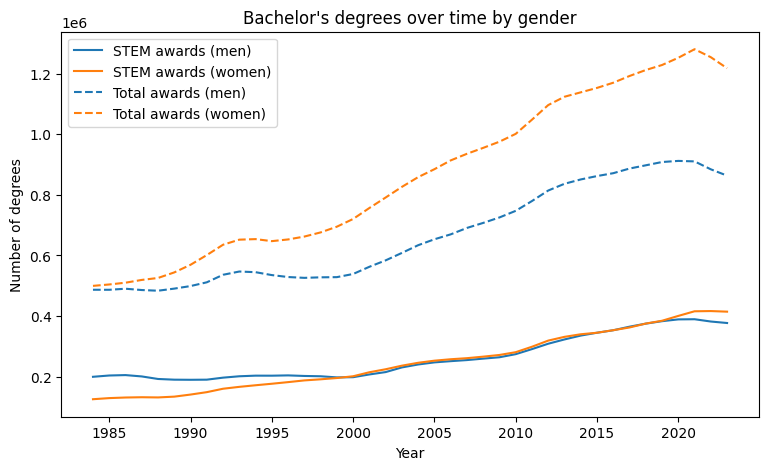

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 5))
g = sns.lineplot(
    stem_by_gender_over_time,
    x="year",
    y="field_degrees_within_gender",
    hue="gender",
)
sns.lineplot(
    stem_by_gender_over_time,
    x="year",
    y="uni_degrees_within_gender",
    hue="gender",
    linestyle="--",
    ax=g,
)
g.set_xlabel("Year")
g.set_ylabel("Number of degrees")
g.set_title("Bachelor's degrees over time by gender")

g.legend()
# Label dashed lines as university totals in legend
g.legend_.texts[0].set_text("STEM awards (men)")
g.legend_.texts[1].set_text("STEM awards (women)")
g.legend_.texts[2].set_text("Total awards (men)")
g.legend_.texts[3].set_text("Total awards (women)")

### Custom queries

If you have a query you want to run that's not covered by the pre-written queries, you can write the SQL yourself and execute it using the engine's `get_df_from_query` function.

You can run any SQL query using this approach, which means you can use SQL to figure out which tables and columns are available in the pre-processed duckdb database file.

In [17]:
query = "SHOW TABLES"

# Using the engine
engine.get_df_from_query(query)

,name
0,cip_info
1,ipeds_completions_a
2,ipeds_directory_info


In [18]:
from scipeds.constants import COMPLETIONS_TABLE

query = f"DESCRIBE {COMPLETIONS_TABLE}"
engine.get_df_from_query(query)

,column_name,column_type,null,key,default,extra
0,year,USMALLINT,YES,None,None,None
1,unitid,UINTEGER,YES,None,None,None
2,cipcode,"ENUM('01.0000', '01.0101', '01.0102', '01.0103...",YES,None,None,None
3,awlevel,"ENUM('Associate''s degree', 'Award of at least...",YES,None,None,None
4,majornum,UTINYINT,YES,None,None,None
5,cip2020,"ENUM('01.0000', '01.0101', '01.0102', '01.0103...",YES,None,None,None
6,race_ethnicity,"ENUM('American Indian or Alaska Native', 'Asia...",YES,None,None,None
7,gender,"ENUM('men', 'women')",YES,None,None,None
8,n_awards,UINTEGER,YES,None,None,None
9,ncses_sci_group,"ENUM('Non-science and engineering', 'Not categ...",YES,None,None,None


You can then use these table and column names to write your own custom SQL:

In [19]:
# Which CIP codes have the most awards over all recorded years?
query = f"""
SELECT cip2020, SUM(n_awards) as total_awards 
FROM {COMPLETIONS_TABLE} 
GROUP BY cip2020 
ORDER BY total_awards DESC;
"""
top_cips = (
    engine.get_df_from_query(query)
    .head(10)
    .set_index("cip2020")
)
top_cips

,total_awards
cip2020,
52.0201,9393674.0
24.0101,8794187.0
51.3801,5832908.0
42.0101,3749035.0
52.0301,2615257.0
26.0101,2348858.0
52.0101,2298456.0
13.1202,2291154.0
24.0102,2283145.0
